# LangGraph Agent Visualization

This notebook visualizes the LangGraph agent structures used in the LLM Bootcamp Project.

## Agent Architectures

The project implements two main LangGraph-based agents:
1. **Agentic RAG Workflow** - Intelligent document question-answering
2. **ReAct Agent** - Web search-enabled conversational agent (via `create_react_agent`)

## Setup and Imports

In [1]:
# Install required packages if needed
# !pip install langchain-openai langgraph graphviz

import os
from typing import TypedDict, Literal, List
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# Set OpenAI API key (optional - only needed if you want to run the graph)
# os.environ["OPENAI_API_KEY"] = "your-key-here"

## 1. Agentic RAG Workflow

The Agentic RAG workflow implements an intelligent document retrieval and generation system with three main nodes:

### Node Structure:
- **START** → Entry point
- **classify_mode** → Determines if query requires "summary" or "fact" response
- **retrieve** → Fetches relevant documents (8 for summary, 3 for facts)
- **generate** → Creates grounded response from retrieved context
- **END** → Terminal node

### State Management:
The workflow uses a typed state dictionary (`RAGState`) to pass information between nodes:
```python
class RAGState(TypedDict):
    question: str                      # User's query
    mode: Literal["summary", "fact"]  # Response strategy
    documents: List[Document]          # Retrieved context
    generation: str                    # Final response
```

In [2]:
# Define RAG state structure
class RAGState(TypedDict):
    """State definition for the RAG workflow."""
    question: str
    mode: Literal["summary", "fact"]
    documents: List[Document]
    generation: str

In [3]:
# Define node functions (simplified for visualization)
def classify_mode(state: RAGState) -> RAGState:
    """Node 1: Classify query type to determine response strategy.
    
    Analyzes the question to determine if user wants:
    - Summary: Overview, key points, synthesis
    - Fact: Specific details, dates, names, numbers
    """
    query_lower = state["question"].lower()
    
    # Summary hints: summarize, overview, key points, etc.
    # Fact hints: when, who, where, amount, specific, etc.
    
    # For demo, default to "fact" mode
    return {**state, "mode": "fact"}

def retrieve(state: RAGState) -> RAGState:
    """Node 2: Retrieve relevant documents based on query and mode.
    
    Retrieval strategy:
    - Summary mode: 8 documents (broader context)
    - Fact mode: 3 documents (focused retrieval)
    """
    # In real implementation, this queries the FAISS vector store
    return {**state, "documents": []}

def generate(state: RAGState) -> RAGState:
    """Node 3: Generate response based on retrieved documents and mode.
    
    Generation strategy:
    - Summary mode: Concise bullet-point summary
    - Fact mode: Precise answer with specific details
    
    Both modes use only the retrieved context (no external knowledge).
    """
    # In real implementation, this invokes the LLM with appropriate prompt
    return {**state, "generation": "Generated response"}

In [4]:
# Build the RAG workflow graph
rag_graph = StateGraph(RAGState)

# Add nodes to the graph
rag_graph.add_node("classify_mode", classify_mode)
rag_graph.add_node("retrieve", retrieve)
rag_graph.add_node("generate", generate)

# Define the workflow edges (linear flow)
rag_graph.set_entry_point("classify_mode")  # START → classify_mode
rag_graph.add_edge("classify_mode", "retrieve")  # classify_mode → retrieve
rag_graph.add_edge("retrieve", "generate")       # retrieve → generate
rag_graph.add_edge("generate", END)              # generate → END

# Compile the graph
rag_workflow = rag_graph.compile()

print("✅ Agentic RAG workflow graph compiled successfully!")

✅ Agentic RAG workflow graph compiled successfully!


### Visualize the RAG Workflow

The graph below shows the complete flow of the Agentic RAG system:

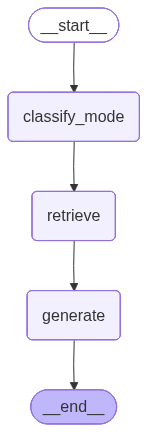

In [5]:
try:
    # Generate and display the graph visualization
    display(Image(rag_workflow.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Note: Visualization requires graphviz. Error: {e}")
    print("\nGraph structure (text representation):")
    print("START → classify_mode → retrieve → generate → END")

### Graph Analysis: Agentic RAG

**Flow Description:**
```
__start__ → classify_mode → retrieve → generate → __end__
```

**Node Descriptions:**

1. **START (`__start__`)**: Entry point for user queries

2. **classify_mode**: 
   - **Type**: Agent Node (decision-making)
   - **Purpose**: Analyzes query intent
   - **Output**: Sets `mode` to "summary" or "fact"
   - **Logic**: Keyword-based classification
     - Summary triggers: "summarize", "overview", "key points"
     - Fact triggers: "when", "who", "where", "amount", "specific"

3. **retrieve**: 
   - **Type**: Agent Node (retrieval)
   - **Purpose**: Fetches relevant documents from vector store
   - **Output**: Populates `documents` list
   - **Strategy**: 
     - Summary mode: 8 documents (broader context)
     - Fact mode: 3 documents (focused retrieval)

4. **generate**: 
   - **Type**: Agent Node (generation)
   - **Purpose**: Creates LLM response using retrieved context
   - **Output**: Populates `generation` field
   - **Constraints**: Only uses retrieved documents (no external knowledge)

5. **END (`__end__`)**: Terminal node, returns final state with `generation`

**Key Features:**
- **Linear workflow**: No conditional edges or loops
- **Type-safe state**: TypedDict ensures proper data flow
- **Mode-adaptive**: Different strategies for summaries vs. facts
- **Grounded generation**: Responses strictly based on retrieved context

---

## 2. ReAct Agent (Search-Enabled Chat)

The ReAct (Reasoning + Acting) agent is created using LangGraph's `create_react_agent` utility. This agent can:
- Reason about user queries
- Search the web using Tavily API
- Combine search results with LLM knowledge

### Architecture:
The ReAct agent uses an internal graph structure (created by `create_react_agent`) with:
- **Agent Node**: Decides whether to use tools or respond directly
- **Tools Node**: Executes tool calls (e.g., Tavily web search)
- **Conditional Edges**: Routes between agent and tools based on reasoning

**Note**: The ReAct agent graph is pre-built by LangGraph. Below is a conceptual representation.

In [6]:
# ReAct Agent conceptual structure
print("""
ReAct Agent Flow (Conceptual):
================================

       START
         |
         v
    [Agent Node] <----------+
         |                  |
         |-- tool_call? ----|--- yes --> [Tools Node]
         |                  |
         |-- no ----------> END

Node Descriptions:
- Agent Node: LLM decides whether to use tools or respond
- Tools Node: Executes Tavily web search
- Conditional Edge: Routes based on agent's reasoning
- Loop: Agent can make multiple tool calls for complex queries

Key Features:
✓ Streaming support for real-time responses
✓ Multi-step reasoning (can chain multiple searches)
✓ Timeout protection (default: 90 seconds)
✓ Automatic tool integration (Tavily search)
""")


ReAct Agent Flow (Conceptual):

       START
         |
         v
    [Agent Node] <----------+
         |                  |
         |-- tool_call? ----|--- yes --> [Tools Node]
         |                  |
         |-- no ----------> END

Node Descriptions:
- Agent Node: LLM decides whether to use tools or respond
- Tools Node: Executes Tavily web search
- Conditional Edge: Routes based on agent's reasoning
- Loop: Agent can make multiple tool calls for complex queries

Key Features:
✓ Streaming support for real-time responses
✓ Multi-step reasoning (can chain multiple searches)
✓ Timeout protection (default: 90 seconds)
✓ Automatic tool integration (Tavily search)



### Code Reference: ReAct Agent Setup

The ReAct agent is created in `langchain_helpers.py` using the `AgentChatbotHelper.setup_agent()` method:

```python
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

# Configure search tool
tavily_search = TavilySearch(
    max_results=5,
    topic="general",
    tavily_api_key=tavily_api_key,
)

# Create agent with tools
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
agent = create_react_agent(llm, tools=[tavily_search])
```

**File Location**: `langchain_helpers.py:137-164`

---

## 3. Running the Agents

### Example: Using the RAG Workflow

In [ ]:
# Example: Running the RAG workflow (requires actual setup)
# This is for demonstration - actual implementation requires:
# 1. Uploaded PDF files
# 2. Built vector store
# 3. Configured LLM

example_query = {
    "question": "What are the key points in this document?",
    "mode": "summary",  # Will be set by classify_mode
    "documents": [],
    "generation": ""
}

print("Example RAG query:")
print(f"Question: {example_query['question']}")
print(f"\nExpected flow:")
print("1. classify_mode → Sets mode to 'summary' (keyword: 'key points')")
print("2. retrieve → Fetches 8 documents from vector store")
print("3. generate → Creates bullet-point summary from documents")
print("4. Returns grounded response")

# To actually run:
# result = rag_workflow.invoke(example_query)
# print(result["generation"])

### Example: Using the ReAct Agent

In [ ]:
# Example: Running the ReAct agent (requires API keys)
# This is for demonstration - actual implementation requires:
# 1. OpenAI API key
# 2. Tavily API key

example_search_query = "What are the latest developments in AI for 2025?"

print("Example ReAct agent query:")
print(f"Question: {example_search_query}")
print(f"\nExpected flow:")
print("1. Agent analyzes query")
print("2. Decides to use Tavily search tool")
print("3. Executes web search")
print("4. Agent processes search results")
print("5. Synthesizes response combining search + LLM knowledge")
print("6. May loop for additional searches if needed")

# To actually run (async):
# from langchain_helpers import AgentChatbotHelper
# agent = AgentChatbotHelper.setup_agent(openai_key, tavily_key)
# response = await AgentChatbotHelper.process_agent_response(agent, example_search_query)

---

## 4. Comparison: RAG vs. ReAct Agent

| Feature | Agentic RAG | ReAct Agent |
|---------|-------------|-------------|
| **Purpose** | Document QA | Web search + Chat |
| **Data Source** | Uploaded PDFs (vector store) | Real-time web search (Tavily) |
| **Graph Type** | Linear (fixed sequence) | Cyclic (tool-calling loops) |
| **Nodes** | 3 agent nodes | 2 nodes (agent + tools) |
| **Conditional Logic** | None (always follows same path) | Yes (decides tool usage) |
| **Response Mode** | Mode-adaptive (summary/fact) | Single strategy |
| **Context Grounding** | Strict (documents only) | Flexible (web + LLM) |
| **Streaming** | Not implemented | Supported |
| **Use Case** | Internal document analysis | Current events, research |

### When to Use Each:

**Agentic RAG**:
- You have proprietary documents (PDFs, reports)
- Need factually grounded responses
- Require citation to source material
- Want consistent, reproducible answers

**ReAct Agent**:
- Need current information (news, prices, etc.)
- Want broad web knowledge
- Require multi-step reasoning
- Need to combine multiple sources

---

## 5. Advanced: State Management

Both agents use typed state management to ensure data consistency across nodes.

In [ ]:
# RAG State - Strongly typed
print("RAG State Structure:")
print("""
class RAGState(TypedDict):
    question: str                      # User query (input)
    mode: Literal["summary", "fact"]  # Response strategy (set by classify_mode)
    documents: List[Document]          # Retrieved context (set by retrieve)
    generation: str                    # Final response (set by generate)
""")

print("\n" + "="*60 + "\n")

# ReAct State - Flexible message-based
print("ReAct State Structure (simplified):")
print("""
{
    "messages": [
        {"role": "user", "content": "user query"},
        {"role": "assistant", "content": "...", "tool_calls": [...]},
        {"role": "tool", "content": "search results"},
        {"role": "assistant", "content": "final response"}
    ]
}
""")

---

## 6. Integration in the Application

### File References:

1. **RAG Implementation**: `langchain_helpers.py:591-728`
   - `RAGHelper.build_simple_agentic_rag()` - Builds the graph
   - `RAGHelper.setup_rag_system()` - Complete setup with vector store

2. **ReAct Implementation**: `langchain_helpers.py:129-228`
   - `AgentChatbotHelper.setup_agent()` - Creates the agent
   - `AgentChatbotHelper.process_agent_response()` - Async response handler

3. **Streamlit Pages**:
   - RAG Page: `pages/3_📄_RAG_Document_Chat.py`
   - Search Page: `pages/2_🔎_Search-Enabled_Chat.py`

### Streamlit Integration Example:

```python
# From pages/3_📄_RAG_Document_Chat.py
from langchain_helpers import RAGHelper

# Setup RAG system
rag_workflow, pii_entities = RAGHelper.setup_rag_system(
    uploaded_files,
    api_key=openai_key,
    anonymize_pii=True,  # Optional PII protection
    use_cache=True       # Enable caching
)

# Process query
result = rag_workflow.invoke({"question": user_query})
answer = result["generation"]
```

---

## Summary

This notebook demonstrated the LangGraph agent architectures used in the LLM Bootcamp Project:

### ✅ Agentic RAG Workflow
- **Nodes**: START → classify_mode → retrieve → generate → END
- **Type**: Linear workflow with no conditional edges
- **Purpose**: Intelligent document QA with mode-adaptive retrieval

### ✅ ReAct Agent
- **Nodes**: Agent Node ↔ Tools Node (with conditional looping)
- **Type**: Cyclic workflow with tool-calling capability
- **Purpose**: Web-enabled conversational AI

### Key Takeaways:
1. Both agents use **typed state management** for reliability
2. RAG provides **grounded, factual** responses from documents
3. ReAct enables **real-time web search** and multi-step reasoning
4. Graphs are **compiled and optimized** by LangGraph for production use

### Next Steps:
- Run `streamlit run Home.py` to see the agents in action
- Upload PDFs to test the RAG workflow
- Try web search queries with the ReAct agent
- Modify node logic in `langchain_helpers.py` to customize behavior